#  GENERATING AUTOMATED IMAGE CAPTION USING CNN AND LSTM


<font size="4">
    
- Image captioning is to automatically generate an image's description, which requires our understanding about content of images.It is a challenging task where computer vision and natural language processing both play a part to generate captions.


- Encoder-CNN is used for extracting features from the image. Decoder-LSTM will use the information from CNN to help generate a description of the image.CNN will identify the objects present in the image then LSTM will start preparing captions considering the objects present in the image.


- The proposed system of Image Caption Generator has the capabilities to Generate Captions for the Images, provided during the training purpose and also for the new images as well.


- A Model takes an Image as Input and by analyzing the image it detects objects present in an image and create a caption which describes the image well ,what an image is trying to say. 

</font>


## DATA COLLECTION

### **Flickr 8k dataset**<font size=4>
    

    
This dataset contains 8000 images each with 5 captions



- Flickr8k_Dataset.zip (1 Gigabyte) An archive of all images.
- Flickr8k_text.zip (2.2 Megabytes) An archive of all text descriptions for each images.


Download


https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

OR

https://www.kaggle.com/adityajn105/flickr8k/activity


- Flickr8k_Dataset: Contains 8092 images in JPEG format.
- Flickr8k_text: Contains a number of files containing different sources of descriptions for the images.

</font>

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.preprocessing import image as ii
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


## Preparing text data

### The dataset contains multiple descriptions for each image and the text of the descriptions requires minimal cleaning.
- load the file containing all of the descriptions(Flicker8k.token.text)

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "D:\IMAGE CAPTIONING\Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:1600])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [ ]:
len(doc)

3395237

##  Creating a description dictionary

###  Descriptions- which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.



In [ ]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
print(descriptions)

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:

descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Cleaning the caption data
.


In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
print(vocabulary)

{'bumpy', 'sparrow', 'flaggers', 'hardwood', 'speech', 'heavy', 'steve', 'stomachs', 'ways', 'tree', 'males', 'urge', 'item', 'everyday', 'autumnal', 'bank', 'cottage', 'instructs', 'crawl', 'wolflike', 'enjoying', 'hundred', 'khaki', 'dc', 'jumper', 'surgical', 'yerba', 'communal', 'film', 'romp', 'hundreds', 'skatepark', 'winter', 'jib', 'peolple', 'idea', 'behing', 'stumbling', 'find', 'yellow', 'attempt', 'stare', 'house', 'multiprint', 'trophy', 'jack', 'cross', 'husky', 'handling', 'calm', 'netted', 'hers', 'armful', 'baggy', 'oncoming', 'tinkerbell', 'boy', 'mediumsized', 'blasts', 'waterskis', 'ruined', 'virtual', 'peer', 'cheerfully', 'receives', 'antitax', 'recoiling', 'sunglasses', 'smokes', 'debris', 'anticipating', 'jumpsuits', 'porch', 'olympics', 'holey', 'fastest', 'proof', 'brothers', 'wrestilng', 'sits', 'air', 'searching', 'exit', 'prarie', 'exercising', 'did', 'rabbit', 'rowers', 'blurry', 'sunset', 'tying', 'measured', 'buddist', 'largeboned', 'placed', 'mambo', 's

## Save description dictionary 

### This function will create a list of all the descriptions that have been preprocessed and store them into a file.

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'D:\IMAGE CAPTIONING\descriptions.txt')

## Loading Training set

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'D:\IMAGE CAPTIONING\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
# Below path contains all the images
images = 'D:/IMAGE CAPTIONING/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [ ]:
train_images_file = 'D:/IMAGE CAPTIONING/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
#print(train_img)

In [ ]:
test_images_file = 'D:/IMAGE CAPTIONING/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
#print(test_img)

## creating training caption

### INPUT_1- Flickr_8k.trainImages.txt(training image identifiers)
### INPUT_2-Descriptions.txt(image identifiers with list of caption)
### OUTPUT- Dictionary train_descriptions(Training image identifier with added tokens on each captions)

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('D:/IMAGE CAPTIONING/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
print(train_descriptions)

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq'], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq'], '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small 

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = ii.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = ii.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

## Building CNN Model


In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

batch_normalization_53 (BatchNo (None, 17, 17, 160)  480         conv2d_53[0][0]                  
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 17, 17, 160)  480         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 17, 17, 160)  0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 17, 17, 160)  0           batch_normalization_58[0][0]     
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 17, 17, 768)  0           mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_51 

## Remove softmax layer from CNN Model


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

batch_normalization_50 (BatchNo (None, 17, 17, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 17, 17, 192)  0           batch_normalization_41[0][0]     
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 17, 17, 192)  0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 17, 17, 192)  0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 17, 17, 192)  0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
mixed5 (Co

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

## Encode train image and save the encoded train feature vector


In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once

#start = time()
#encoding_train = {}
#for img in train_img:
    #encoding_train[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

#output->Time taken in seconds = 6627.559219837189

In [ ]:
#import pickle
# Save the bottleneck train features to disk
#with open("D:\Program files\pro materials\Automatic-Image-Captioning-master\Datasets\Pickle\encoded_train_images.pkl", "wb") as encoded_pickle:
   # pickle.dump(encoding_train, encoded_pickle)


In [ ]:
import pickle
encoded_pickle=open("D:\IMAGE CAPTIONING\pickle\encoded_train_images.pkl", "rb")
train_features=pickle.load(encoded_pickle)

In [ ]:
print('Photos: train=%d' % len(train_features))

Photos: train=6000


## Encode test image and save the encoded test feature vector

In [ ]:
# Call the funtion to encode all the test images - Execute this only once

#start = time()
#encoding_test = {}
#for img in test_img:
   # encoding_test[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

#output->Time taken in seconds = 924.5848045349121

In [ ]:
# Save the bottleneck test features to disk
#with open("D:\Program files\pro materials\Automatic-Image-Captioning-master\Datasets\Pickle\encoded_test_images.pkl", "wb") as encoded_pickle:
    #pickle.dump(encoding_test, encoded_pickle)

In [ ]:
import pickle
encoded_pickle=open("D:\IMAGE CAPTIONING\pickle\encoded_test_images.pkl", "rb")
test_features=pickle.load(encoded_pickle)

In [ ]:
print('Photos: train=%d' % len(test_features))

Photos: train=1000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 3 times in the corpus
word_count_threshold = 3
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 3471


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
print(ixtoword)

{1: 'startseq', 2: 'child', 3: 'in', 4: 'pink', 5: 'dress', 6: 'is', 7: 'climbing', 8: 'up', 9: 'set', 10: 'of', 11: 'stairs', 12: 'an', 13: 'way', 14: 'endseq', 15: 'girl', 16: 'going', 17: 'into', 18: 'wooden', 19: 'building', 20: 'little', 21: 'playhouse', 22: 'the', 23: 'to', 24: 'her', 25: 'cabin', 26: 'black', 27: 'dog', 28: 'and', 29: 'spotted', 30: 'are', 31: 'fighting', 32: 'tricolored', 33: 'playing', 34: 'with', 35: 'each', 36: 'other', 37: 'on', 38: 'road', 39: 'white', 40: 'brown', 41: 'spots', 42: 'staring', 43: 'at', 44: 'street', 45: 'two', 46: 'dogs', 47: 'different', 48: 'breeds', 49: 'looking', 50: 'pavement', 51: 'moving', 52: 'toward', 53: 'covered', 54: 'paint', 55: 'sits', 56: 'front', 57: 'painted', 58: 'rainbow', 59: 'hands', 60: 'bowl', 61: 'sitting', 62: 'large', 63: 'small', 64: 'grass', 65: 'plays', 66: 'canvas', 67: 'it', 68: 'there', 69: 'pigtails', 70: 'painting', 71: 'young', 72: 'outside', 73: 'man', 74: 'lays', 75: 'bench', 76: 'while', 77: 'his', 78:

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

3472

## Maximum length of caption

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Word Embedding

In [ ]:
# Load Glove vectors
glove_dir = 'D:\IMAGE CAPTIONING\Glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(3472, 200)

## LSTM MODEL

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      694400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      694400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
              yield [array(X1), array(X2)], array(y)
              X1, X2, y = list(), list(), list()
              n=0
                #out = ([array(X1), array(X2)], array(y))
                #yield out
                #X1, X2, y = list(), list(), list()
                #n=0
                

## Training the model

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save_weights('D:\IMAGE CAPTIONING\model_weight2\model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 3126s 2s/step - loss: 4.3899 - accuracy: 0.2320
Epoch 1/1
2000/2000 [==============================] - 3389s 2s/step - loss: 3.6069 - accuracy: 0.2852
Epoch 1/1
2000/2000 [==============================] - 3391s 2s/step - loss: 3.3417 - accuracy: 0.3041
Epoch 1/1
2000/2000 [==============================] - 3316s 2s/step - loss: 3.1751 - accuracy: 0.3163
Epoch 1/1
2000/2000 [==============================] - 3186s 2s/step - loss: 3.0529 - accuracy: 0.3253
Epoch 1/1
2000/2000 [==============================] - 3162s 2s/step - loss: 2.9601 - accuracy: 0.3325
Epoch 1/1
2000/2000 [==============================] - 3176s 2s/step - loss: 2.8828 - accuracy: 0.3395
Epoch 1/1
2000/2000 [==============================] - 3067s 2s/step - loss: 2.8257 - accuracy: 0.3453
Epoch 1/1
2000/2000 [==============================] - 2610s 1s/step - loss: 2.7738 - accuracy: 0.3508
Epoch 1/1
2000/2000 [==============================] - 3902s 2s/step - lo

In [ ]:
epochs = 10
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save_weights('D:\IMAGE CAPTIONING\model_weight2\model_' + str(i+10) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 2566s 1s/step - loss: 2.6953 - accuracy: 0.3592
Epoch 1/1
2000/2000 [==============================] - 2591s 1s/step - loss: 2.6639 - accuracy: 0.3618
Epoch 1/1
2000/2000 [==============================] - 2640s 1s/step - loss: 2.6375 - accuracy: 0.3661
Epoch 1/1
2000/2000 [==============================] - 3966s 2s/step - loss: 2.6121 - accuracy: 0.3678
Epoch 1/1
2000/2000 [==============================] - 3182s 2s/step - loss: 2.5900 - accuracy: 0.3711
Epoch 1/1
2000/2000 [==============================] - 3699s 2s/step - loss: 2.5699 - accuracy: 0.3732
Epoch 1/1
2000/2000 [==============================] - 2928s 1s/step - loss: 2.5526 - accuracy: 0.3759
Epoch 1/1
2000/2000 [==============================] - 36280s 18s/step - loss: 2.5376 - accuracy: 0.3775
Epoch 1/1
2000/2000 [==============================] - 3905s 2s/step - loss: 2.5187 - accuracy: 0.3797
Epoch 1/1
2000/2000 [==============================] - 4048s 2s/step - 

In [ ]:
epochs = 10
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save_weights('D:\IMAGE CAPTIONING\model_weight2\model_' + str(i+20) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 4094s 2s/step - loss: 2.4963 - accuracy: 0.3826
Epoch 1/1
2000/2000 [==============================] - 3343s 2s/step - loss: 2.4827 - accuracy: 0.3847
Epoch 1/1
2000/2000 [==============================] - 2722s 1s/step - loss: 2.4735 - accuracy: 0.3866
Epoch 1/1
2000/2000 [==============================] - 2729s 1s/step - loss: 2.4649 - accuracy: 0.3871
Epoch 1/1
2000/2000 [==============================] - 2729s 1s/step - loss: 2.4528 - accuracy: 0.3892
Epoch 1/1
2000/2000 [==============================] - 2978s 1s/step - loss: 2.4449 - accuracy: 0.3907
Epoch 1/1
2000/2000 [==============================] - 2709s 1s/step - loss: 2.4378 - accuracy: 0.3907
Epoch 1/1
2000/2000 [==============================] - 2733s 1s/step - loss: 2.4292 - accuracy: 0.3927
Epoch 1/1
2000/2000 [==============================] - 2738s 1s/step - loss: 2.4209 - accuracy: 0.3934
Epoch 1/1
2000/2000 [==============================] - 2791s 1s/step - lo

In [ ]:
model.load_weights('D:\IMAGE CAPTIONING\model_weight2\model_29.h5')

In [ ]:
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    history=model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model.save_weights('D:\IMAGE CAPTIONING\model_weight2\model_40.h5')
pickle.dump()

Epoch 1/1
1000/1000 [==============================] - 2377s 2s/step - loss: 2.4479 - accuracy: 0.3916
Epoch 1/1
1000/1000 [==============================] - 2383s 2s/step - loss: 2.4046 - accuracy: 0.3970
Epoch 1/1
1000/1000 [==============================] - 2390s 2s/step - loss: 2.3899 - accuracy: 0.3996
Epoch 1/1
1000/1000 [==============================] - 2535s 3s/step - loss: 2.3747 - accuracy: 0.4015
Epoch 1/1
1000/1000 [==============================] - 2410s 2s/step - loss: 2.3647 - accuracy: 0.4038
Epoch 1/1
1000/1000 [==============================] - 2426s 2s/step - loss: 2.3536 - accuracy: 0.4052
Epoch 1/1
1000/1000 [==============================] - 2362s 2s/step - loss: 2.3444 - accuracy: 0.4068
Epoch 1/1
1000/1000 [==============================] - 2355s 2s/step - loss: 2.3380 - accuracy: 0.4075
Epoch 1/1
1000/1000 [==============================] - 2368s 2s/step - loss: 2.3292 - accuracy: 0.4086
Epoch 1/1
1000/1000 [==============================] - 2370s 2s/step - lo

In [ ]:
model.save_weights('D:\IMAGE CAPTIONING\model_weight2\model_40.h5')

In [ ]:
model.load_weights('D:\IMAGE CAPTIONING\model_weight2\model_40.h5')

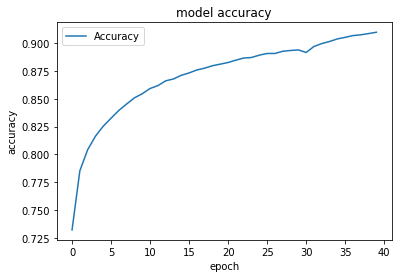

In [ ]:
import pandas as pd
df = pd.read_csv('D:\IMAGE CAPTIONING\loss-accuracy1.csv')
# summarize history for accuracy
plt.plot(df['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

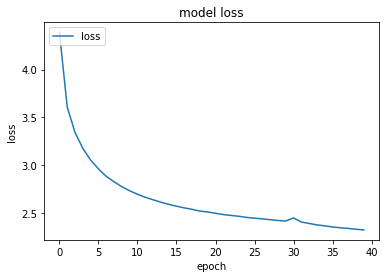

In [ ]:
# summarize history for loss
plt.plot(df['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [ ]:
images = "D:\\IMAGE CAPTIONING\\Flicker8k_Dataset\\"

In [ ]:
with open("D:\Program files\pro materials\Automatic-Image-Captioning-master\Datasets\Pickle\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

## Predicting caption of an image

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Predicting caption

In [ ]:
import nltk

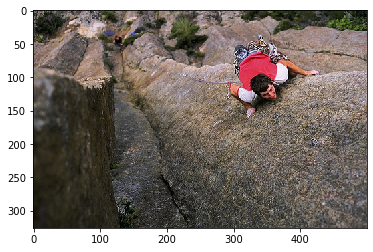

Greedy: man is climbing up huge rock

Reference 1: mam climbing on the mountain
Reference 2: mam in red shrit climbing on the mountain
Reference 3: mam is climbing up on the rock mountain

BLEU-1: 0.8
BLEU-2: 0.77
BLEU-3: 0.768
BLEU-4: 0.7681

METEOR: 0.48076923076923084


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#from nltk.translate import meteor_score
#from nltk.translate.meteor_score import meteor_score as meteor 

r1 = 'mam climbing on the mountain'
r2 = 'mam in red shrit climbing on the mountain'
r3 = 'mam is climbing up on the rock mountain'


z=98
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()

caption=greedySearch(image)
print("Greedy:",caption)
print()
print('Reference 1:',r1)
print('Reference 2:',r2)
print('Reference 3:',r3)
print()
print('BLEU-1:', round(sentence_bleu([r1, r2, r3], caption),1))
print('BLEU-2:', round(sentence_bleu([r1, r2, r3], caption),2))
print('BLEU-3:', round(sentence_bleu([r1, r2, r3], caption),3))

print('BLEU-4:', round(sentence_bleu([r1, r2, r3], caption),4))
print()
print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

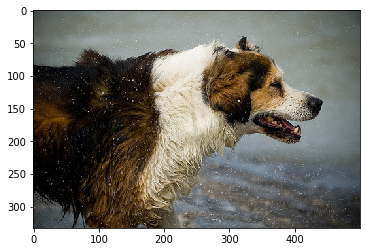

Greedy: dog is running through water

Reference 1: the dog is playing
Reference 2: brown dog is playing in the water
Reference 3: A brown with white dog is running though the water

BLEU-1: 0.8
BLEU-2: 0.75
BLEU-3: 0.75
BLEU-4: 0.7503

METEOR: 0.45731707317073167


In [ ]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#from nltk.translate import meteor_score
#from nltk.translate.meteor_score import meteor_score as meteor 

r1 = 'the dog is playing'
r2 = 'brown dog is playing in the water'
r3 = 'A brown with white dog is running though the water'


z=7
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()

caption=greedySearch(image)
print("Greedy:",caption)
print()
print('Reference 1:',r1)
print('Reference 2:',r2)
print('Reference 3:',r3)
print()
print('BLEU-1:', round(sentence_bleu([r1, r2, r3], caption),1))
print('BLEU-2:', round(sentence_bleu([r1, r2, r3], caption),2))
print('BLEU-3:', round(sentence_bleu([r1, r2, r3], caption),3))

print('BLEU-4:', round(sentence_bleu([r1, r2, r3], caption),4))
print()
print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

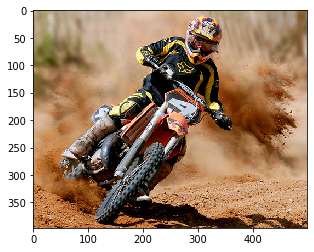

Greedy: man on bicycle is riding on dirt road

Reference 1: man riding bicycle on dirt road
Reference 2: man in black jacket riding bicycle on dirt road during daytime
Reference 3: man riding motorbike on dirt road

BLEU-1: 0.8
BLEU-2: 0.81
BLEU-3: 0.811
BLEU-4: 0.8106

METEOR: 0.8243727598566307


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#from nltk.translate import meteor_score
#from nltk.translate.meteor_score import meteor_score as meteor 

r1 = 'man riding bicycle on dirt road'
r2 = 'man in black jacket riding bicycle on dirt road during daytime'
r3 = 'man riding motorbike on dirt road'


z=428
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()

caption=greedySearch(image)
print("Greedy:",caption)
print()
print('Reference 1:',r1)
print('Reference 2:',r2)
print('Reference 3:',r3)
print()
print('BLEU-1:', round(sentence_bleu([r1, r2, r3], caption),1))
print('BLEU-2:', round(sentence_bleu([r1, r2, r3], caption),2))
print('BLEU-3:', round(sentence_bleu([r1, r2, r3], caption),3))

print('BLEU-4:', round(sentence_bleu([r1, r2, r3], caption),4))
print()
print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

In [ ]:
model_json = model.to_json()
with open("D:\\approach2_model.json", "w") as json_file:
    json_file.write(model_json)

# TEST CASES

In [ ]:
from keras.models import model_from_json

json_file = open('D:\\approach2_model.json', 'r')
model_json = json_file.read()
json_file.close()
caption_model = model_from_json(model_json)
caption_model.load_weights('C:\\Users\\ELCOT\\Downloads\\model_weight2\\model_40.h5')
images = 'D:\\IMAGE CAPTIONING\\Flicker8k_Dataset\\'

## Data augmentation technique-Rotation

Greedy Search Caption: white dog is running through the grass

BLEU-1: 0.6
BLEU-2: 0.65
BLEU-3: 0.647
BLEU-4: 0.6467
METEOR: 0.4746835443037974


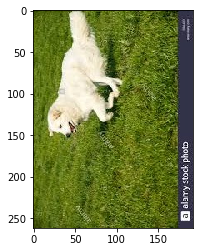

In [ ]:
#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
r1 = ' whit dog is playing in though the grass'
#r2 = 'a girl with golden hair is sitting'
#r3 = 'a person is sitting'
pic = list(encoding_test.keys())[788]
#print(pic)
img = 'D:\\IMAGE CAPTIONING\\testcase images\\black1.jpg'
e = encode(img).reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(images+pic)
x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
#print('Reference 1:',r1)
#print('Reference 2:',r2)
#print('Reference 3:',r3)
#print()
#print('BLEU:', round(sentence_bleu([r1, r2, r3], caption),3))
print('BLEU-1:', round(sentence_bleu([r1], caption),1))
print('BLEU-2:', round(sentence_bleu([r1], caption),2))
print('BLEU-3:', round(sentence_bleu([r1], caption),3))

print('BLEU-4:', round(sentence_bleu([r1], caption),4))

print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

## Grayscale image

Greedy Search Caption: two dogs are playing together on the grass among trees

BLEU-1: 1.0
BLEU-2: 0.98
BLEU-3: 0.981
BLEU-4: 0.9809
METEOR: 1.0966942148760332


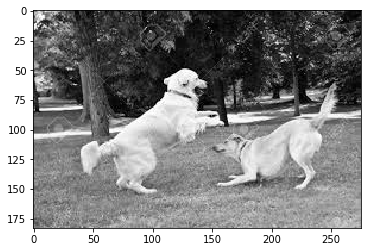

In [ ]:
#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
r1 = 'two dogs are playing together on the grass among tree'
#r2 = 'a girl with golden hair is sitting'
#r3 = 'a person is sitting'
pic = list(encoding_test.keys())[788]
#print(pic)
img = 'C:\\Users\\ELCOT\\Downloads\\output-onlinejpgtools.jpg'
e = encode(img).reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(images+pic)
x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
#print('Reference 1:',r1)
#print('Reference 2:',r2)
#print('Reference 3:',r3)
#print()
#print('BLEU:', round(sentence_bleu([r1, r2, r3], caption),3))
print('BLEU-1:', round(sentence_bleu([r1], caption),1))
print('BLEU-2:', round(sentence_bleu([r1], caption),2))
print('BLEU-3:', round(sentence_bleu([r1], caption),3))

print('BLEU-4:', round(sentence_bleu([r1], caption),4))

print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

## Ambiguous image

Greedy Search Caption: dog is running through the snow

BLEU-1: 0.3
BLEU-2: 0.29
BLEU-3: 0.293
BLEU-4: 0.2935
METEOR: 0.16666666666666666


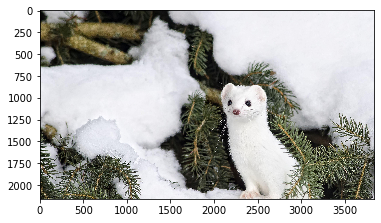

In [ ]:
#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
r1 = 'bear is sitting on a snow'
#r2 = 'a girl with golden hair is sitting'
#r3 = 'a person is sitting'
pic = list(encoding_test.keys())[788]
#print(pic)
img = 'D:\\IMAGE CAPTIONING\\testcase images\\confuse.jpg'
e = encode(img).reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(images+pic)
x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
#print('Reference 1:',r1)
#print('Reference 2:',r2)
#print('Reference 3:',r3)
#print()
#print('BLEU:', round(sentence_bleu([r1, r2, r3], caption),3))
print('BLEU-1:', round(sentence_bleu([r1], caption),1))
print('BLEU-2:', round(sentence_bleu([r1], caption),2))
print('BLEU-3:', round(sentence_bleu([r1], caption),3))

print('BLEU-4:', round(sentence_bleu([r1], caption),4))

print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

Greedy Search Caption: hockey player keeps the puck as the other team observe

BLEU-1: 1.0
BLEU-2: 1.0
BLEU-3: 1.0
BLEU-4: 1.0
METEOR: 0.9995


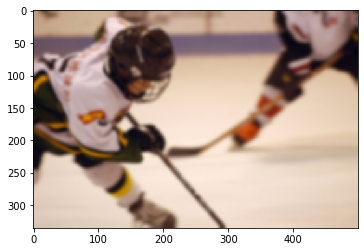

In [ ]:
#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
r1 = 'hockey player keeps the puck as the other team observe'
#r2 = 'a girl with golden hair is sitting'
#r3 = 'a person is sitting'
pic = list(encoding_test.keys())[788]
#print(pic)
img = 'D:\\IMAGE CAPTIONING\\testcase images\\blur1.jpg'
e = encode(img).reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(images+pic)
x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
#print('Reference 1:',r1)
#print('Reference 2:',r2)
#print('Reference 3:',r3)
#print()
#print('BLEU:', round(sentence_bleu([r1, r2, r3], caption),3))
print('BLEU-1:', round(sentence_bleu([r1], caption),1))
print('BLEU-2:', round(sentence_bleu([r1], caption),2))
print('BLEU-3:', round(sentence_bleu([r1], caption),3))

print('BLEU-4:', round(sentence_bleu([r1], caption),4))

print ('METEOR:',nltk.translate.meteor_score.meteor_score(
    [r1,r2,r3], caption))

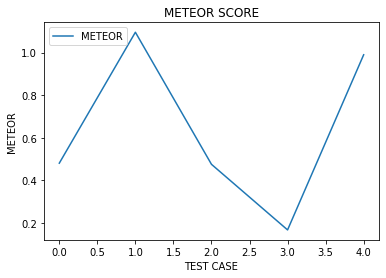

In [ ]:
import pandas as pd
df = pd.read_csv('D:\\IMAGE CAPTIONING\\bl.csv')
# summarize history for accuracy
plt.plot(df['meteor'])
#plt.plot(df['bl1'])
#plt.plot(df['bl2'])
#plt.plot(df['bl3'])
#plt.plot(df['tc5'])

plt.title('METEOR SCORE')
plt.ylabel('METEOR')
plt.xlabel('TEST CASE')
plt.legend(['METEOR'], loc='upper left')
#plt.legend(['TEST CASES-2'], loc='upper left')
#plt.legend(['TEST CASES-3'], loc='upper left')
#plt.legend(['TEST CASES-4'], loc='upper left')
#plt.legend(['TEST CASES-5'], loc='upper left')

plt.show()

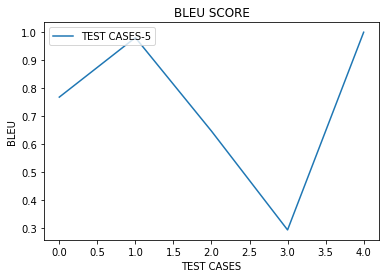

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
df = pd.read_csv('D:\\IMAGE CAPTIONING\\bl4.csv')

plt.plot(df['bleu4'])


plt.title('BLEU SCORE')
plt.ylabel('BLEU')
plt.xlabel('TEST CASES')
plt.legend(['TEST CASES-1'], loc='upper left')
plt.legend(['TEST CASES-2'], loc='upper left')
plt.legend(['TEST CASES-3'], loc='upper left')
plt.legend(['TEST CASES-4'], loc='upper left')
plt.legend(['TEST CASES-5'], loc='upper left')

plt.show()

# CONCLUTION
<font size = 4 >The proposed LSTM model that generates a descriptive sentence for an image by taking future context into account. An image is often rich in content. The model should be able to generate caption corresponding to multiple main objects presented in the images with multiple target objects and the relationship between the objects, instead of just describing a single target object. For corpus description languages of different languages, a general image description system capable of handling multiple languages should be developed. Evaluating the result of natural language generation systems is a difficult problem. The best way to evaluate the quality of automatically generated texts is subjective assessment by linguists, which is hard to achieve. In order to improve system performance, the evaluation indicators should be optimized to make them more in line with human expert’s assessments. A very real problem is the speed of training, testing, and generating sentences for the model should be optimized to improve performance. The future work will focus on exploring more sophisticated language representation and incorporating an attention mechanism into this model. It would also be interesting to explore the multilingual caption generation problem. Also apply this models to other sequence learning task such as text recognition and video captioning. In future work, try to extent this model as neural visual storyteller.</font size>